<a href="https://colab.research.google.com/github/2022Group3/projectNotebooks/blob/main/analize_model_not_confident_trash_hold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from keras.models import load_model
import numpy as np
import sys
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from PIL import Image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
model=load_model(r'drive/MyDrive/keras_cifar10_trained_model_1A.h5')
# csv_data= pd.read_csv(r'drive/MyDrive/data.csv')

In [6]:
def load_dataset():
  data=np.load(r'drive/MyDrive/data_modified.npz')
  data=dict(zip(("{}".format(k) for k in data),(data[k] for k in data)))
  trainX=data['train']
  trainy=data['ytrain']
  validationX=data['validation']
  validationy=data['yvalidation']
  testX=data['test']
  testy=data['ytest']
  return trainX,to_categorical(trainy),validationX,to_categorical(validationy),testX,to_categorical(testy)

In [7]:
# scale pixels
def prep_pixels(testX):
  # convert from integers to floats
  testX_norm = testX.astype('float32')
  # normalize to range 0-1
  testX_norm = testX_norm / 255.0
  
  # return normalized images
  return testX_norm

In [8]:
trainX,trainy,validationX,validationy,testX,testy=load_dataset()

In [9]:
testy.shape

(22524, 16)

In [10]:
# x_test=testX
testX=prep_pixels(testX)
# y_test=testy
# testy=to_categorical(testy)

In [38]:
# 1
# Dif between 2 first. Green if first predict is true, Else red.
def img_pred_and_sum_of_d(pred1, pred2, real):
  if pred1[0] == real:
    good_pred = True
  else:
    good_pred = False
  dif= pred1[1]- pred2[1]
  return good_pred, dif


def plot_graph(testy, pred):
  good_pred_list= []
  dif_list= []
  for i in range(len(testy)):
    pred1= [np.argmax(pred[i]), np.max(pred[i])*100]
    pred[i, np.argmax(pred[i])]=0.0
    pred2= [np.argmax(pred[i]), np.max(pred[i])*100]
    good_pred,dif = img_pred_and_sum_of_d(pred1, pred2, np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)), dif_list, c=mycolors, s=1)
  plt.xlabel('image index')
  plt.ylabel('dif between first and second place pred')
  plt.show()

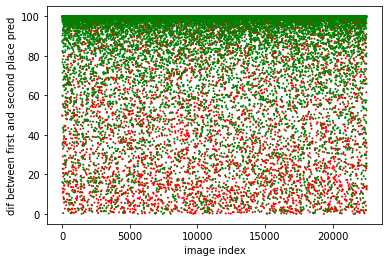

In [39]:
plot_graph(testy, model.predict(testX))

In [40]:
# 2
# Dif between 2 first. Green if true in first predict or second. Else red 
def img_pred_and_sum_of_d2(pred1, pred2, real):
  if pred1[0] == real or pred2[0] == real:
    good_pred = True
  else:
    good_pred = False
  dif= pred1[1]- pred2[1]
  return good_pred, dif

def plot_graph2(testy, pred):
  good_pred_list= []
  dif_list= []
  for i in range(len(testy)):
    pred1= [np.argmax(pred[i]), np.max(pred[i])*100]
    pred[i, np.argmax(pred[i])]=0.0
    pred2= [np.argmax(pred[i]), np.max(pred[i])*100]
    good_pred,dif = img_pred_and_sum_of_d2(pred1, pred2, np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)), dif_list, c=mycolors, s=1)
  plt.xlabel('image index')
  plt.ylabel('dif between first and second place pred')
  plt.show()

 

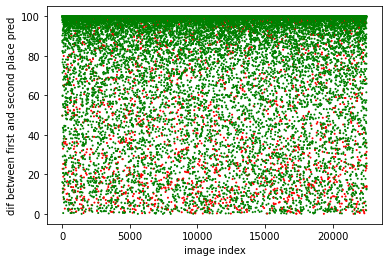

In [41]:
plot_graph2(testy, model.predict(testX))

In [42]:
# 3
# Sum of dif between sorted predicts array. Green if first predict is true

def img_pred_and_sum_of_d_all(pred1, preds, real):

  if pred1 == real:
    good_pred = True
  else:
    good_pred = False
  sorted_preds= np.sort(preds)[::-1]
  # print(sorted_preds)
  sumdif=0
  for i in range(len(sorted_preds)-1):
    sumdif+= sorted_preds[i]-sorted_preds[i+1]
  
  return good_pred, sumdif

def plot_graph_all(testy, preds):
  good_pred_list= []
  dif_list= []
  for i in range(len(testy)):
    pred1= np.argmax(preds[i])
    good_pred,dif = img_pred_and_sum_of_d_all(pred1, preds[i], np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)), dif_list, c=mycolors, s=1)
  plt.xlabel('image index')
  plt.ylabel('dif between first and second place pred')
  plt.show()



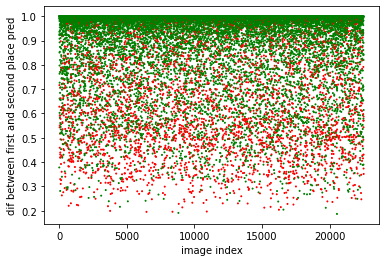

In [43]:
plot_graph_all(testy, model.predict(testX))




In [54]:
# 4
# Sum of probs dif and sum of 2 highest proba
def img_pred_and_sum_of_d_all2(pred1, preds, real):

  if pred1 == real:
    good_pred = True
  else:
    good_pred = False
  sorted_preds= np.sort(preds)[::-1]
  # print(sorted_preds)
  sumdif=0
  for i in range(len(sorted_preds)-1):
    sumdif+= sorted_preds[i]-sorted_preds[i+1]
  sum_two_first= sorted_preds[0]+sorted_preds[1]
  
  return good_pred, sumdif, sum_two_first

def plot_graph_all_sum(testy, preds):
  good_pred_list= []
  dif_list= []
  sum_two_first_list= []
  for i in range(len(testy)):
    pred1= np.argmax(preds[i])
    good_pred,dif, sum_two_first = img_pred_and_sum_of_d_all2(pred1, preds[i], np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    dif_list.append(dif)
    sum_two_first_list.append(sum_two_first)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(sum_two_first_list, dif_list, c=mycolors, s=1)
  plt.xlabel('Sum of first and second prob')
  plt.ylabel('Sum all probabilty diff')
  plt.show()

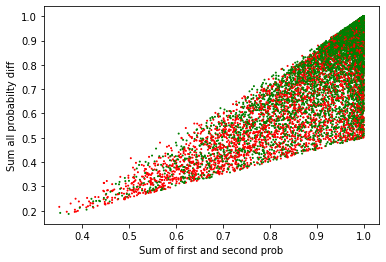

In [55]:
plot_graph_all_sum(testy, model.predict(testX))


In [61]:
# 5
# sum of proba with weights by first place, swcond place and so on...
def img_sum_pred_weight(pred1, preds, real):

  if pred1 == real:
    good_pred = True
  else:
    good_pred = False

  sorted_preds= np.sort(preds)[::-1]
  sum_weight=0
  num_proba= len(preds)
  for i in range(len(sorted_preds)-1):
    sum_weight+= (sorted_preds[i])*(num_proba-i)*(num_proba-i)*(num_proba-i)
  
  return good_pred, sum_weight

def plot_graph_all_sum3(testy, preds):
  good_pred_list= []
  sum_weight_list= []
  for i in range(len(testy)):
    pred1= np.argmax(preds[i])
    good_pred,sum_weight = img_sum_pred_weight(pred1, preds[i], np.argmax(testy[i]))
    good_pred_list.append(good_pred)
    sum_weight_list.append(sum_weight)
  mycolors= [('g' if i else 'r') for i in good_pred_list]
  plt.scatter(np.arange(0,len(testy)),sum_weight_list , c=mycolors, s=1)
  plt.xlabel('Image index')
  plt.ylabel('Sum all probabilty with weights')
  plt.show()

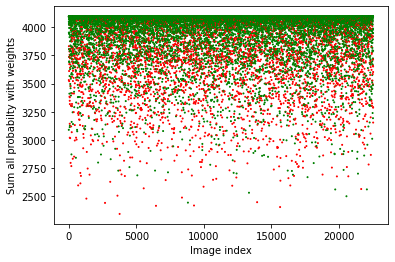

In [62]:
plot_graph_all_sum3(testy, model.predict(testX))
